# Classifying Images

## Working with a Set of Images

In [1]:
from skimage.io import imread
from skimage.transform import resize 
from matplotlib import pyplot as plt
import matplotlib.cm as cm

In [2]:
%matplotlib inline

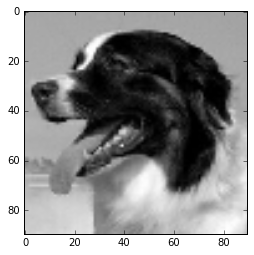

In [3]:
example_file = ("http://upload.wikimedia.org/" +
    "wikipedia/commons/7/7d/Dog_face.png")
image = imread(example_file, as_grey=True)
plt.imshow(image, cmap=cm.gray)
plt.show()

In [4]:
import warnings
warnings.filterwarnings("ignore")
from skimage import filters, restoration
from skimage.morphology import disk
median_filter = filters.rank.median(image, disk(1))
tv_filter = restoration.denoise_tv_chambolle(image, weight=0.1)
gaussian_filter = filters.gaussian_filter(image, sigma=0.7)

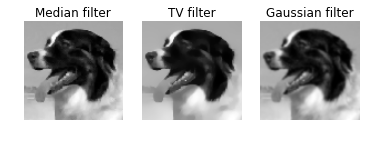

In [5]:
fig = plt.figure()
for k,(t,F) in enumerate((('Median filter',median_filter), 
                        ('TV filter',tv_filter), 
                        ('Gaussian filter', gaussian_filter))):
    f=fig.add_subplot(1,3,k+1)
    plt.axis('off')
    f.set_title(t)
    plt.imshow(F, cmap=cm.gray)
plt.show()

In [6]:
print("data type: %s, shape: %s" % 
      (type(image), image.shape))

data type: <class 'numpy.ndarray'>, shape: (90, 90)


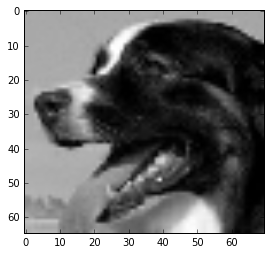

In [7]:
image2 = image[5:70,0:70]
plt.imshow(image2, cmap=cm.gray)
plt.show()

data type: <class 'numpy.ndarray'>, shape: (30, 30)


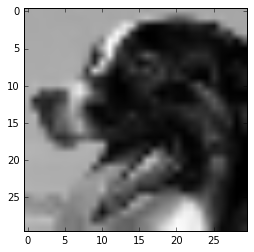

In [8]:
image3 = resize(image2, (30, 30), mode='nearest')
plt.imshow(image3, cmap=cm.gray)
print("data type: %s, shape: %s" % 
      (type(image3), image3.shape))

In [9]:
image_row = image3.flatten()
print("data type: %s, shape: %s" % 
      (type(image_row), image_row.shape))

data type: <class 'numpy.ndarray'>, shape: (900,)


##Extracting Visual Features

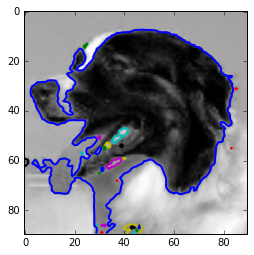

In [10]:
from skimage import measure
contours = measure.find_contours(image, 0.55)
plt.imshow(image, cmap=cm.gray)
for n, contour in enumerate(contours):
    plt.plot(contour[:, 1], contour[:, 0], linewidth=2)
plt.axis('image')
plt.show()

##Recognizing Faces by eigenfaces

In [11]:
import numpy as np
from sklearn.datasets import fetch_olivetti_faces
dataset = fetch_olivetti_faces(shuffle=True, random_state=101)
train_faces = dataset.data[:350,:]
test_faces  = dataset.data[350:,:]
train_answers = dataset.target[:350]
test_answers = dataset.target[350:]

In [12]:
print (dataset.DESCR)

Modified Olivetti faces dataset.

The original database was available from (now defunct)

    http://www.uk.research.att.com/facedatabase.html

The version retrieved here comes in MATLAB format from the personal
web page of Sam Roweis:

    http://www.cs.nyu.edu/~roweis/

There are ten different images of each of 40 distinct subjects. For some
subjects, the images were taken at different times, varying the lighting,
facial expressions (open / closed eyes, smiling / not smiling) and facial
details (glasses / no glasses). All the images were taken against a dark
homogeneous background with the subjects in an upright, frontal position (with
tolerance for some side movement).

The original dataset consisted of 92 x 112, while the Roweis version
consists of 64x64 images.



In [13]:
from sklearn.decomposition import RandomizedPCA
n_components = 25
Rpca = RandomizedPCA(n_components=n_components, 
            whiten=True, random_state=101).fit(train_faces)
print ('Explained variance by %i components: %0.3f' % 
       (n_components, np.sum(Rpca.explained_variance_ratio_)))
compressed_train_faces = Rpca.transform(train_faces)
compressed_test_faces  = Rpca.transform(test_faces)

Explained variance by 25 components: 0.794


We are looking for face id=34


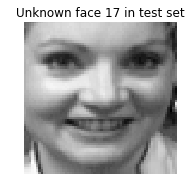

In [14]:
import matplotlib.pyplot as plt
photo = 17 # This is the photo in the test set we want to know about
print ('We are looking for face id=%i' % test_answers[photo])
plt.subplot(1, 2, 1)
plt.axis('off')
plt.title('Unknown face '+str(photo)+' in test set')
plt.imshow(test_faces[photo].reshape(64,64), cmap=plt.cm.gray
           , interpolation='nearest')
plt.show()

In [15]:
mask = compressed_test_faces[photo,] #Just the vector of value components of our photo
squared_errors = np.sum((compressed_train_faces - mask)**2,axis=1)
minimum_error_face = np.argmin(squared_errors)
most_resembling = list(np.where(squared_errors < 20)[0])
print ('Best resembling face in train test: %i' % 
       train_answers[minimum_error_face])

Best resembling face in train test: 34


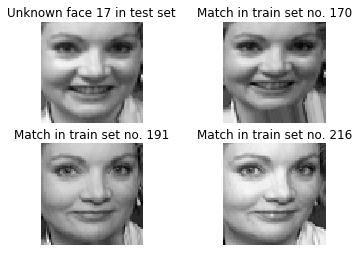

In [16]:
import matplotlib.pyplot as plt
plt.subplot(2, 2, 1)
plt.axis('off')
plt.title('Unknown face '+str(photo)+' in test set')
plt.imshow(test_faces[photo].reshape(64,64), 
           cmap=plt.cm.gray, interpolation='nearest')
for k,m in enumerate(most_resembling[:3]):
   plt.subplot(2, 2, 2+k)
   plt.title('Match in train set no. '+str(m))
   plt.axis('off')
   plt.imshow(train_faces[m].reshape(64,64), 
              cmap=plt.cm.gray, interpolation='nearest')
plt.show()

## Classifying Images

In [17]:
import warnings
warnings.filterwarnings("ignore")
from sklearn.datasets import fetch_lfw_people
lfw_people = fetch_lfw_people(min_faces_per_person=60,
                              resize=0.4)
X = lfw_people.data
y = lfw_people.target
target_names = [lfw_people.target_names[a] for a in y]
n_samples, h, w = lfw_people.images.shape
from collections import Counter
for name, count in Counter(target_names).items():
    print ("%20s %i" % (name, count))

        Ariel Sharon 77
   Junichiro Koizumi 60
        Colin Powell 236
   Gerhard Schroeder 109
          Tony Blair 144
         Hugo Chavez 71
       George W Bush 530
     Donald Rumsfeld 121


#### The first time the previous cell will be run it will download over 200MB in data from http://vis-www.cs.umass.edu/lfw and decompress it into your hard disk. The procedure will also produce some warnings to be ignored

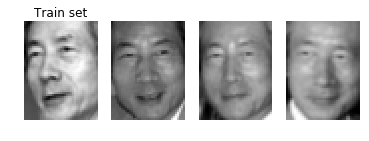

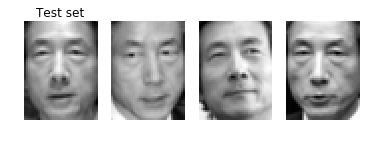

In [18]:
from sklearn.cross_validation import StratifiedShuffleSplit
train, test = list(StratifiedShuffleSplit(target_names, 
            n_iter=1, test_size=0.1, random_state=101))[0]

plt.subplot(1, 4, 1)
plt.axis('off')
for k,m in enumerate(X[train][y[train]==6][:4]):
    plt.subplot(1, 4, 1+k)
    if k==0:
        plt.title('Train set')
    plt.axis('off')
    plt.imshow(m.reshape(50,37), 
               cmap=plt.cm.gray, interpolation='nearest')
plt.show()

for k,m in enumerate(X[test][y[test]==6][:4]):
    plt.subplot(1, 4, 1+k)
    if k==0:
        plt.title('Test set')
    plt.axis('off')
    plt.imshow(m.reshape(50,37), 
               cmap=plt.cm.gray, interpolation='nearest')
plt.show()

In [19]:
from sklearn import decomposition
n_components = 50
pca = decomposition.RandomizedPCA(n_components=n_components,
                                  whiten=True).fit(X[train,:])
nmf = decomposition.NMF(n_components=n_components, 
                        init='nndsvda', tol=5e-3).fit(X[train,:])
fastica = decomposition.FastICA(n_components=n_components,
                                whiten=True).fit(X[train,:])
eigenfaces = pca.components_.reshape((n_components, h, w))
X_dec = np.column_stack((pca.transform(X[train,:]), 
        nmf.transform(X[train,:]), fastica.transform(X[train,:])))
Xt_dec = np.column_stack((pca.transform(X[test,:]), 
        nmf.transform(X[test,:]), fastica.transform(X[test,:])))
y_dec = y[train]
yt_dec = y[test]

In [20]:
from sklearn.grid_search import GridSearchCV
from sklearn.svm import SVC
param_grid = {'C': [0.1, 1.0, 10.0, 100.0, 1000.0],
              'gamma': [0.0001, 0.001, 0.01, 0.1], }
clf = GridSearchCV(SVC(kernel='rbf'), param_grid)
clf = clf.fit(X_dec, y_dec)
print ("Best parameters: %s" % clf.best_params_)

Best parameters: {'gamma': 0.01, 'C': 100.0}


In [21]:
from sklearn.metrics import accuracy_score
solution = clf.predict(Xt_dec)
print("Achieved accuracy: %0.3f" % accuracy_score(yt_dec, solution))

Achieved accuracy: 0.815


In [22]:
from sklearn.metrics import confusion_matrix
confusion = str(confusion_matrix(yt_dec, solution))
print (' '*26+ '  '.join(map(str,range(8))))
print (' '*26+ '-'*22)
for n, (label, row) in enumerate(zip(lfw_people.target_names,
                                     confusion.split('\n'))):
    print ('%s %18s > %s' % (n, label, row))


                          0  1  2  3  4  5  6  7
                          ----------------------
0       Ariel Sharon > [[ 6  0  1  0  1  0  0  0]
1       Colin Powell >  [ 0 22  0  2  0  0  0  0]
2    Donald Rumsfeld >  [ 0  0  8  2  1  0  0  1]
3      George W Bush >  [ 1  1  2 46  1  0  0  2]
4  Gerhard Schroeder >  [ 0  0  2  1  6  1  0  1]
5        Hugo Chavez >  [ 0  0  0  0  1  5  0  1]
6  Junichiro Koizumi >  [ 0  0  0  0  0  0  6  0]
7         Tony Blair >  [ 0  0  0  1  2  0  0 11]]
